In [1]:
import sys, os
sys.path.append(os.path.abspath("../"))  


In [3]:
import pandas as pd
from core.factors import *




In [19]:
df = pd.read_parquet('../data/twse_2020_to_2025.parquet')

In [20]:

high = df.pivot(index="date", columns="stock_id", values="high").sort_index().shift(1)
low  = df.pivot(index="date", columns="stock_id", values="low").sort_index().shift(1)
vol = df.pivot(index="date", columns="stock_id", values="volume").sort_index().shift(1)
close = df.pivot(index="date", columns="stock_id", values="close").sort_index().shift(1)
open = df.pivot(index="date", columns="stock_id", values="open").sort_index().shift(1)


### Momentum

In [21]:
m1 = (normalize(open-close))
m2 = normalize(high-low)
m3 = normalize(vol/(ts_mean(vol)))
momentum = rank_cs((m1+m2))*m3

## alpha 101

In [22]:
from core.factors import *

# close: DataFrame (date×asset)
delta1 = ts_delta(close, 1)
tsmin4 = ts_min(delta1, 4)
tsmax4 = ts_max(delta1, 4)

# condition logic
cond1 = greater(tsmin4, 0)
cond2 = less(tsmax4, 0)

# nested ternary condition
temp = where(cond1, delta1, where(cond2, delta1, mul(-1, delta1)))

# final cross-sectional rank
alpha10 = rank_cs(temp)


In [23]:
from core.factors import *

# high, volume: DataFrame (index=date, columns=asset)
rank_high = rank_cs(high)
rank_vol  = rank_cs(vol)

# 每檔股票：rank_high 與 rank_vol 的 3日相關係數
corr_3d = corr_ts(rank_high, rank_vol, d=3)

# 當天 cross-sectional rank
rank_corr = rank_cs(corr_3d)

# 再取 3 日 rolling sum
sum3 = ts_sum(rank_corr, d=3)

# 最後乘以 -1
alpha15 = -1 * sum3


In [24]:
returns = close.pct_change()
amount = vol*close                        # 日報酬
adv20   = ts_mean(amount, d=20)                    # 20日平均成交額
vwap    = amount / vol                          # 加權平均價
spread  = high - close                             # 高低差

# --- 3. combine terms ---
alpha25 = (-1 * returns) * adv20 * vwap * spread

# --- 4. cross-sectional rank (橫截面排名)
alpha25 = rank_cs(alpha25)

/tmp/ipykernel_41655/4084360021.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close.pct_change()


In [28]:
alpha_158_9  = (2 * close - high - low) / (high - low + 1e-12)


In [31]:
vwap    = amount / vol                          

alpha_158_11 = (close - low) / (high - low + 1e-12)
alpha_158_12 = (close - open) / (high - open + 1e-12)
alpha_158_13 = (open - low) / (high - low + 1e-12)
alpha_158_14 = (high - close) / (high - low + 1e-12)

alpha_158_15 = open - ts_sum(vwap, 10) / 10

alpha_158_16 = close - vwap
alpha_158_17 = close - open
alpha_158_18 = ts_delta(close, 1)
alpha_158_19 = ts_delta(close, 5)
alpha_158_20 = ts_delta(close, 10)


/home/echiu/.local/lib/python3.10/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/home/echiu/.local/lib/python3.10/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/home/echiu/.local/lib/python3.10/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method

Dropped 0.8% entries from factor data: 0.7% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.029,0.005,-0.008
beta,0.086,0.084,0.074
Mean Period Wise Return Top Quantile (bps),0.420,0.129,-0.305
Mean Period Wise Return Bottom Quantile (bps),-2.475,-1.176,-0.357
Mean Period Wise Spread (bps),2.895,1.314,0.059


<Figure size 640x480 with 0 Axes>

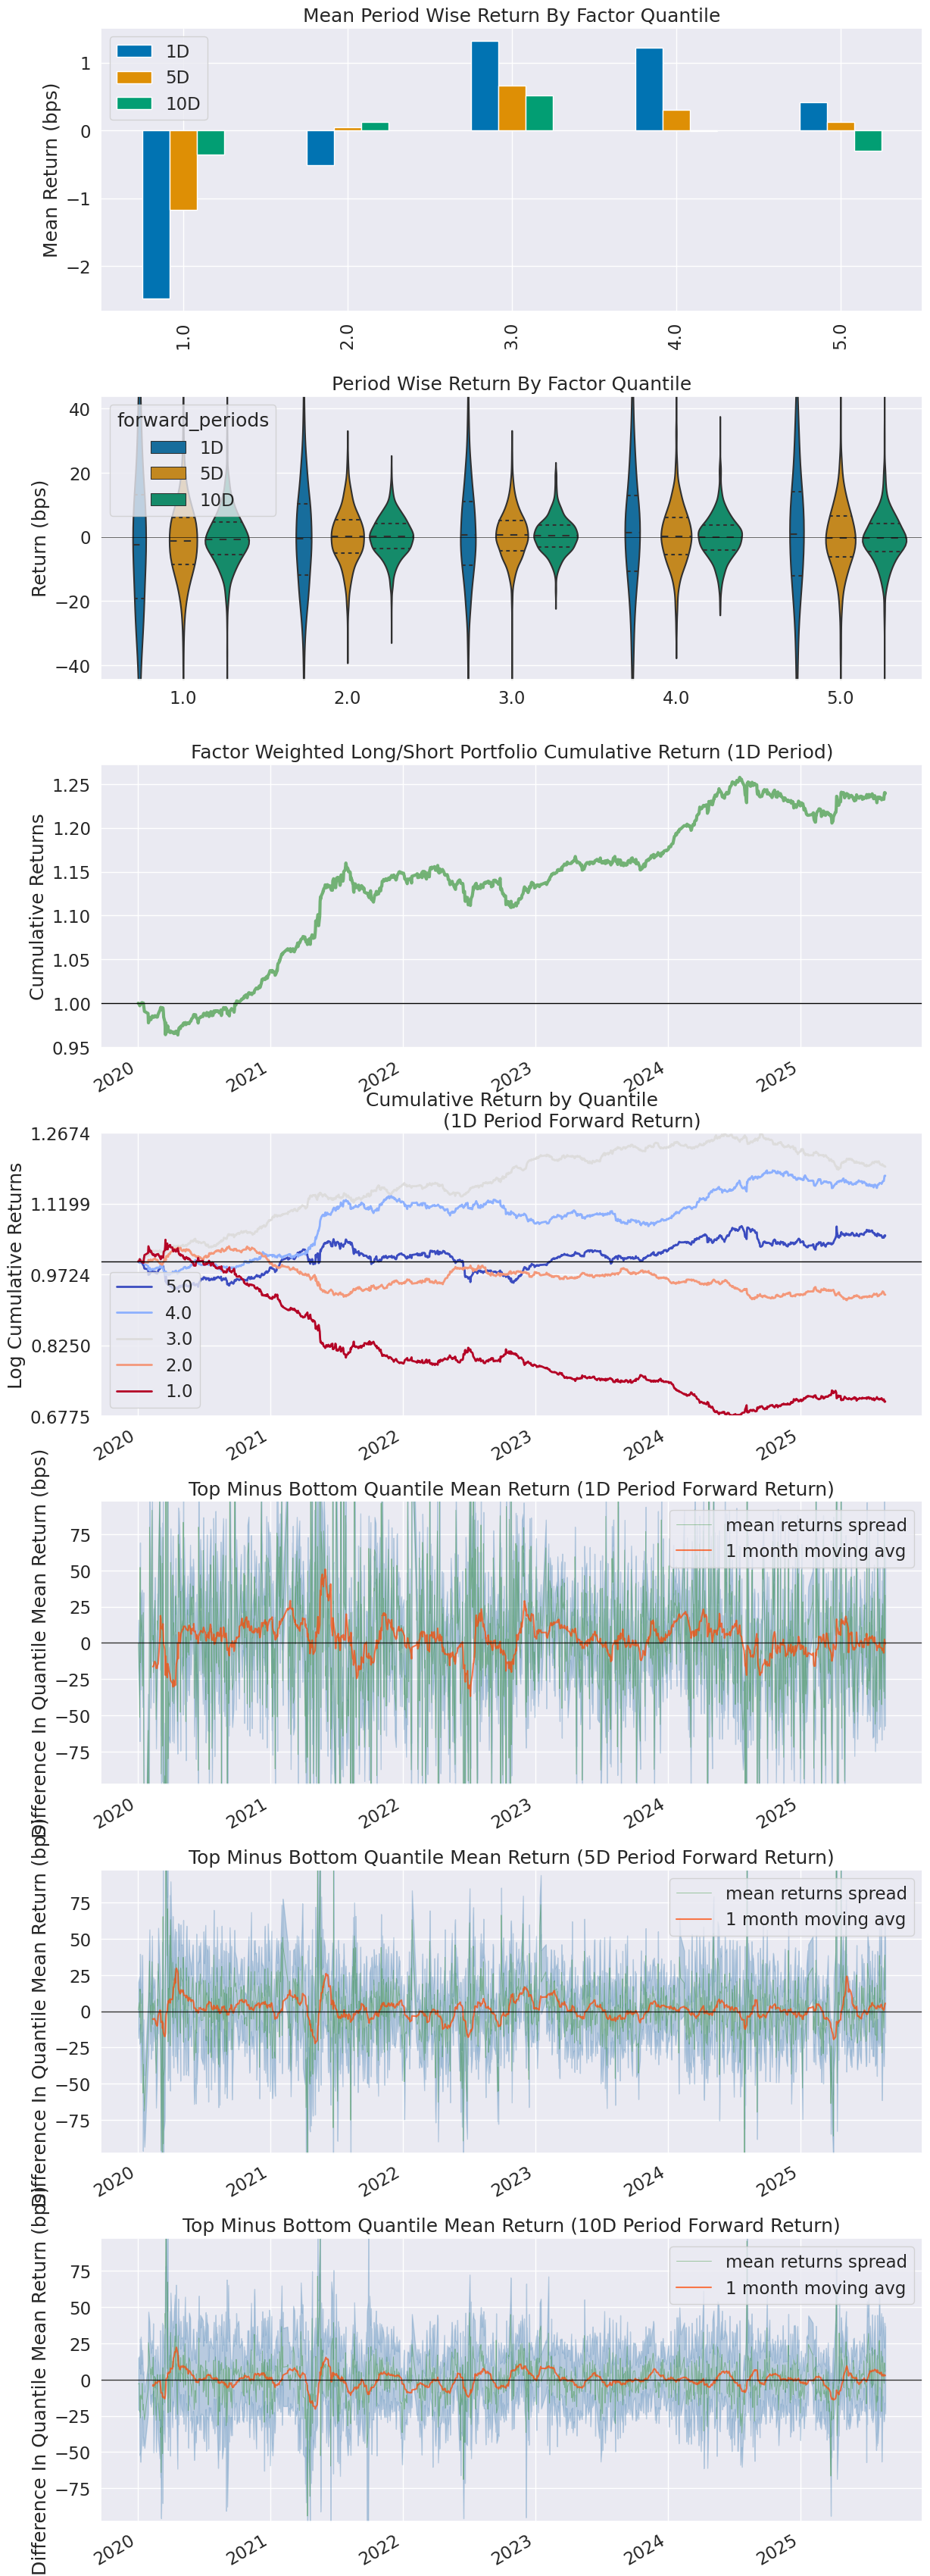

In [34]:
factor = to_factor_df(-alpha_158_9)
import alphalens as al
prices = df.pivot(index="date", columns="stock_id", values="close").sort_index()
factor_data = al.utils.get_clean_factor_and_forward_returns(factor=factor, prices=prices, periods=[1,5,10])
al.tears.create_returns_tear_sheet(factor_data)
